In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
# from src.multi_vae_pemb import CrossSpeciesVAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

In [2]:
adata1 = anndata.read_h5ad('data/wagner/data.h5ad')
adata2 = anndata.read_h5ad('data/briggs/data.h5ad')

adata1.X = adata1.X.astype('float32')
adata2.X = adata2.X.astype('float32')

emb1 = pickle.load(open('data/wagner/gene_embeddings.pkl','rb'))
emb2 = pickle.load(open('data/briggs/gene_embeddings.pkl','rb'))

emb1 = torch.cat([torch.tensor(emb1[i]).unsqueeze(-2) for i in adata1.var_names],dim=0).float()
emb2 = torch.cat([torch.tensor(emb2[i]).unsqueeze(-2) for i in adata2.var_names],dim=0).float()

I found that homology edges derived from ESM-C give better-than-random mappings. Real signal.


Learning rate needs to be lower to get integration to be better, I've found, but warmup epochs needs to be increased (5.0)


Homologous gene pairs give much better within-species reconstructions. I feel like we probably need a skip connection for the protein embedding model.

Currently trying with a skip connection in the frozen embedding layer.
The skip connection helps a lot for within-species, but it ruins the cross species loss. Need to try out the inverse embeddings instead.

Next try with your default learning weights




Observations:
1. higher learning rate is better for making mappings reproducible
2. homology score initialization doesn't seem to help matters for reproducibility?
3. if homology score directions are not set to the same set of score parameters, then they diverge quite a lot.

In [3]:
XY_raw = _united_proj(emb1.numpy(), emb2.numpy(), k=25, metric='euclidean')
YX_raw = _united_proj(emb2.numpy(), emb1.numpy(), k=25, metric='euclidean')

XY = XY_raw.copy()
YX = YX_raw.copy()
XY.data[:]=1
YX.data[:]=1

G = XY + YX.T

G.data[G.data>1]=0
G.eliminate_zeros()
x, y = G.nonzero()


G = XY_raw/2 + YX_raw.T/2
G[x,y] = 0
G.eliminate_zeros()
x, y = G.nonzero()

homology_edges = {}
homology_edges[0] = {}
homology_edges[0][1] = torch.tensor(np.vstack((x,y)).T)

homology_edges[1] = {}
homology_edges[1][0] = torch.tensor(np.vstack((y,x)).T)

homology_scores = {}
homology_scores[0] = {}
homology_scores[0][1] = torch.tensor(G.data).float()

homology_scores[1] = {}
homology_scores[1][0] = torch.tensor(G.data).float()

In [4]:
species_data = {
    "wagner": adata1,
    "briggs": adata2,
}

emb_data = {
    "wagner": emb1,
    "briggs": emb2, 
}
data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=512,
    num_workers=0,
    val_split=0.001,
    test_split=0.001,
    yield_pairwise=False,
    subsample_size=10000,
    subsample_by={
        "wagner": "cell_type",
        "briggs": "cell_type",   
    }
)
data_module.setup()

species_data_sub = {k: data_module.train_dataset.epoch_data[k][data_module.train_dataset.epoch_indices[k]].copy() for k in data_module.train_dataset.epoch_data}

batch_size = 512

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
    labels={
        "wagner": "cell_type",
        "briggs": "cell_type",
    }
)
data_module.setup()

emb_data = {data_module.train_dataset.species_to_idx[k]: v for k,v in emb_data.items()}

In [5]:
species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    direct_recon_weight=1.0,
    cross_species_recon_weight=1.0,

    triplet_epoch_start=0.5,
    triplet_loss_margin=0.2,
    
    transform_weight=0.0, #from 0.1
    base_learning_rate=1e-2,
    min_learning_rate=1e-4,
    
    warmup_data=0.1,
    homology_score_momentum=0.9,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=11,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=4,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: Your `IterableDataset` has `__len__` defined. In 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Found 2924 triplets
Found 2865 triplets


`Trainer.fit` stopped: `max_epochs=4` reached.


4


KeyError: 'train_latent_alignment'

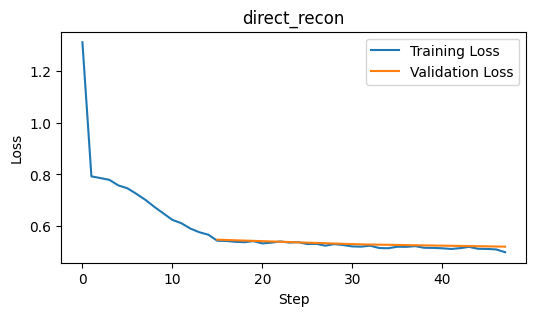

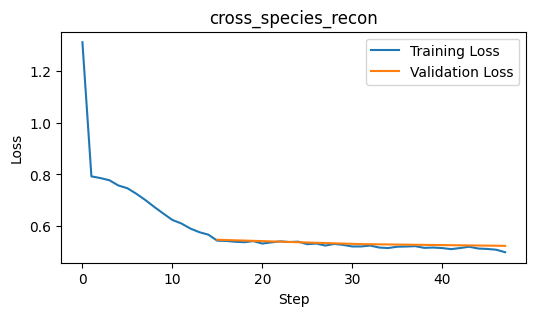

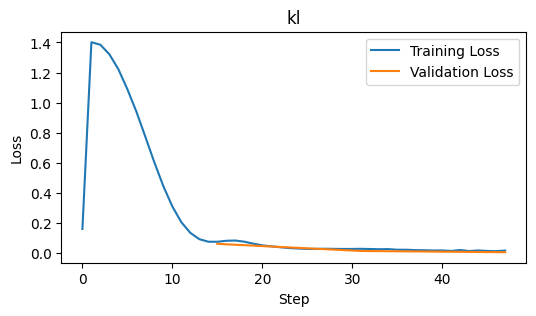

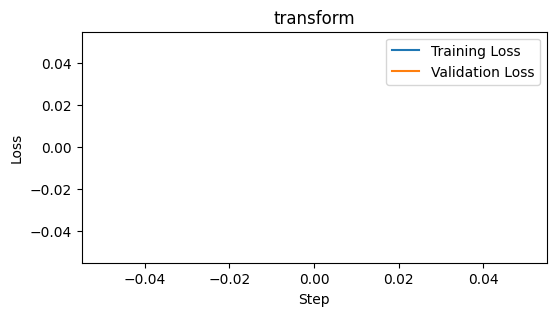

In [7]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["direct_recon","cross_species_recon", "kl", "transform", "triplet"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

# Saving
# save_dict = {
#     'state_dict': model.state_dict(),
#     'hyper_parameters': model.hparams,
#     'epoch': 99,
# }
# torch.save(save_dict, f'manual_checkpoint_epoch_{99}.pt')

In [17]:
output, s = model.get_latent_embeddings(species_data_sub, batch_size=4096)
s=s.cpu().numpy()

In [18]:
plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())

<Figure size 640x480 with 0 Axes>

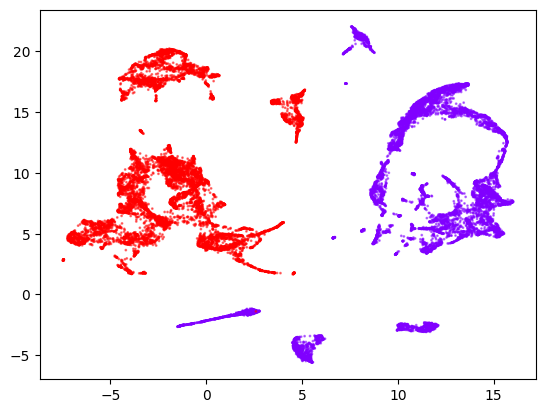

In [19]:
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

0.4866987853505382
0.4743653727774338


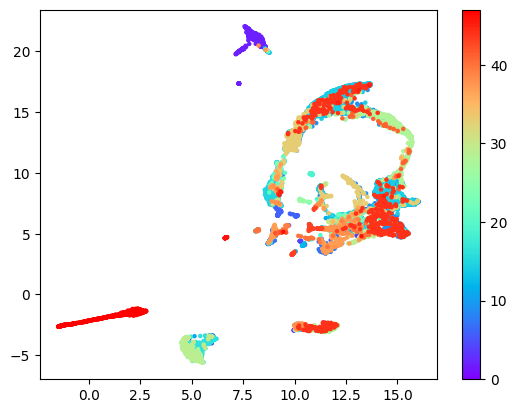

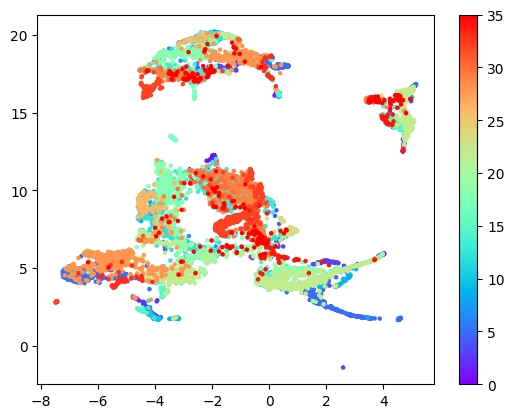

In [20]:

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [21]:
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"



import plotly.graph_objects as go
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.io as pio
pio.renderers.default = 'notebook'
def create_sankey_from_similarity(
    similarity_matrix: np.ndarray,
    source_labels: list,
    target_labels: list,
    threshold: float = 0.1,
    title: str = "Cross-species Label Similarity",
    width: int = 1000,
    height: int = 800
) -> go.Figure:
    """
    Create a Sankey diagram from a bipartite similarity matrix with weighted edges.
    """
    # Create node labels
    labels = source_labels + target_labels
    
    # Create source, target, and value arrays for links
    sources = []
    targets = []
    values = []
    
    # Create hover text for links
    link_labels = []
    
    # Iterate through similarity matrix
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i,j] > threshold:
                sources.append(i)
                targets.append(j + len(source_labels))
                values.append(similarity_matrix[i,j])
                link_labels.append(f"{source_labels[i]} → {target_labels[j]}: {similarity_matrix[i,j]:.3f}")
    
    # Normalize values to make them more visually appealing
    values = np.array(values)
    values = values / values.max() * 100  # Scale to 0-100 range for better visualization
    
    # Create color arrays for nodes
    node_colors = ['#1f77b4'] * len(source_labels) + ['#ff7f0e'] * len(target_labels)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            customdata = link_labels,
            color = ['rgba(31, 119, 180, 0.4)'] * len(sources),  # Semi-transparent links
            hovertemplate = '%{customdata}<extra></extra>'
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=width,
        height=height,
        showlegend=False,
        margin=dict(t=40, l=40, r=40, b=40)
    )
    
    # Display in notebook
    # fig.show(renderer="notebook")
    return fig

def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "wagner",
    target_species: str = "briggs",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df

K = 50
latent = output.cpu().numpy()

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


# mapping tables

In [22]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [23]:
similarity_df['briggs']

Blastula                                     Blood  \
              matched_type similarity                   matched_type   
0              pluripotent   4.511178                    pluripotent   
1                    Blood   1.674531                       periderm   
2                 Germline   1.349178  neural - floorplate posterior   
3          Skeletal muscle   1.005285                        Tailbud   
4  Rare epidermal subtypes   0.724673                Skeletal muscle   
5                 Ionocyte   0.610813            Secretory epidermal   
6          Pronephric duct   0.591156             Rohon-beard neuron   
7     Epidermal progenitor   0.378184        Rare epidermal subtypes   
8                 Endoderm   0.369655                Pronephric duct   
9               Macrophage   0.279769            Presomitic mesoderm   

              Cement gland primordium                            Endoderm  \
  similarity             matched_type similarity             matched_type   
0  11.686459              pluripotent   4.680142              pluripotent   
1   0.000000                Notochord   0.169191                 Germline   
2   0.000000         Dorsal organizer   0.092470                    Blood   
3   0.000000                      EVL   0.077155                 Ionocyte   
4   0.000000                 Endoderm   0.021030          Skeletal muscle   
5   0.000000                 Ionocyte   0.015405     Epidermal progenitor   
6   0.000000  Rare epidermal subtypes   0.012175                 Endoderm   
7   0.000000     Epidermal progenitor   0.006488  Rare epidermal subtypes   
8   0.000000          Pronephric duct   0.000000      Presomitic mesoderm   
9   0.000000      Presomitic mesoderm   0.000000          Pronephric duct   

                                Endothelial             \
  similarity                   matched_type similarity   
0  15.600590                    pluripotent   7.061843   
1   0.121195                       periderm   0.000000   
2   0.083770  neural - floorplate posterior   0.000000   
3   0.055821                        Tailbud   0.000000   
4   0.051205                Skeletal muscle   0.000000   
5   0.036177            Secretory epidermal   0.000000   
6   0.032532             Rohon-beard neuron   0.000000   
7   0.027837        Rare epidermal subtypes   0.000000   
8   0.019232                Pronephric duct   0.000000   
9   0.018593            Presomitic mesoderm   0.000000   

       Epidermal progenitor                            Eye primordium  \
               matched_type similarity                   matched_type   
0               pluripotent  49.336568                    pluripotent   
1                     Blood   0.277663                       periderm   
2  Involuting marginal zone   0.049552  neural - floorplate posterior   
3                  Germline   0.020471                        Tailbud   
4           Skeletal muscle   0.016143                Skeletal muscle   
5        Forebrain/midbrain   0.014454            Secretory epidermal   
6      Epidermal progenitor   0.012915             Rohon-beard neuron   
7       Presomitic mesoderm   0.008617        Rare epidermal subtypes   
8                 Hindbrain   0.006068                Pronephric duct   
9                  Ionocyte   0.005378            Presomitic mesoderm   

                         Forebrain/midbrain             \
  similarity                   matched_type similarity   
0  16.017745                    pluripotent  13.292761   
1   0.000000                       Germline   0.005536   
2   0.000000  neural - floorplate posterior   0.000000   
3   0.000000                       periderm   0.000000   
4   0.000000                Skeletal muscle   0.000000   
5   0.000000            Secretory epidermal   0.000000   
6   0.000000             Rohon-beard neuron   0.000000   
7   0.000000                        Tailbud   0.000000   
8   0.000000                Pronephric duct   0.000000   
9   0.000000    

In [24]:
similarity_df['wagner']

Apoptotic-like                  Apoptotic-like 2             \
            matched_type similarity           matched_type similarity   
0                Tailbud        0.0                Tailbud        0.0   
1      Spemann organizer        0.0      Spemann organizer        0.0   
2  Small secretory cells        0.0  Small secretory cells        0.0   
3        Skeletal muscle        0.0        Skeletal muscle        0.0   
4     Rohon-beard neuron        0.0     Rohon-beard neuron        0.0   
5  Pronephric mesenchyme        0.0  Pronephric mesenchyme        0.0   
6    Presomitic mesoderm        0.0    Presomitic mesoderm        0.0   
7          Placodal area        0.0          Placodal area        0.0   
8           Otic placode        0.0           Otic placode        0.0   
9                  Optic        0.0                  Optic        0.0   

                      Blood                    Dorsal organizer             \
               matched_type similarity             matched_type similarity   
0                  Blastula   1.674531              Goblet cell   0.201541   
1             Neuroectoderm   0.682642           Hatching gland   0.134617   
2       Non-neural ectoderm   0.589334  Cement gland primordium   0.092470   
3  Involuting marginal zone   0.297913          Skeletal muscle   0.055061   
4      Epidermal progenitor   0.277663                 Blastula   0.010375   
5               Goblet cell   0.257443     Epidermal progenitor   0.002150   
6                  Endoderm   0.083770    Intermediate mesoderm   0.000868   
7                  Germline   0.028583                  Tailbud   0.000000   
8         Spemann organizer   0.012236    Small secretory cells   0.000000   
9           Skeletal muscle   0.000000        Spemann organizer   0.000000   

                       EVL                             Endoderm             \
              matched_type similarity              matched_type similarity   
0  Cement gland primordium   0.077155                  Blastula   0.369655   
1                  Tailbud   0.000000  Involuting marginal zone   0.034147   
2    Small secretory cells   0.000000                  Endoderm   0.032532   
3        Spemann organizer   0.000000             Neuroectoderm   0.022603   
4          Skeletal muscle   0.000000   Cement gland primordium   0.021030   
5       Rohon-beard neuron   0.000000               Goblet cell   0.017269   
6      Presomitic mesoderm   0.000000       Non-neural ectoderm   0.015503   
7    Pronephric mesenchyme   0.000000                  Germline   0.014202   
8             Otic placode   0.000000         Spemann organizer   0.014195   
9                    Optic   0.000000      Epidermal progenitor   0.004304   

             Endothelial                 Epidermal progenitor             \
            matched_type similarity              matched_type similarity   
0                Tailbud        0.0                  Blastula   0.378184   
1      Spemann organizer        0.0             Neuroectoderm   0.067847   
2  Small secretory cells        0.0  Involuting marginal zone   0.059213   
3        Skeletal muscle        0.0       Non-neural ectoderm   0.046564   
4     Rohon-beard neuron        0.0                  Endoderm   0.036177   
5  Pronephric mesenchyme        0.0               Goblet cell   0.022991   
6    Presomitic mesoderm        0.0         Spemann organizer   0.013159   
7          Placodal area        0.0      Epidermal progenitor   0.012915   
8           Otic placode        0.0                  Germline   0.009868   
9                  Optic        0.0   Cement gland primordium   0.006488   

          Eye primordium                   Forebrain/midbrain             \
            matched_type similarity              matched_type similarity   
0                Tailbud        0.0                  Blastula   0.099902   
1      Spemann organizer        0.0             Neuroectoderm   0.054149   
2  Small secretory cells        0.0       

In [25]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2024-12-12 00:15:47,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-12 00:15:48,907 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-12 00:15:48,942 - harmonypy - INFO - Iteration 1 of 10
2024-12-12 00:15:52,679 - harmonypy - INFO - Iteration 2 of 10
2024-12-12 00:15:56,471 - harmonypy - INFO - Iteration 3 of 10
2024-12-12 00:16:00,281 - harmonypy - INFO - Converged after 3 iterations


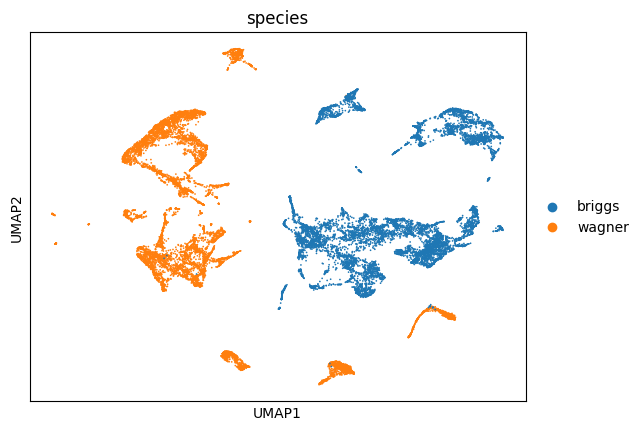

In [26]:
sc.pl.umap(adata,color='species')

In [27]:
K = 50
latent = adata.obsm['X_pca_harmony']

nnm = _united_proj(latent[s==1],latent[s==0], k=K, metric='cosine')
x, y = nnm.nonzero()
indices_x = x.reshape((nnm.shape[0],K))
indices_y = y.reshape((nnm.shape[0],K))
similarities = nnm.data.reshape((nnm.shape[0],K))


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices_y].flatten()
df['labels_1'] = cl2[indices_x].flatten()
df['similarities'] = similarities.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)


In [28]:
similarity_df = format_cross_species_similarities(C, clu1, clu2, top_n=10)

In [29]:
similarity_df['briggs']

Blastula                                     Blood             \
            matched_type similarity                   matched_type similarity   
0             Macrophage   8.348563                    pluripotent  11.643791   
1               Endoderm   3.848298       Involuting marginal zone   0.308481   
2                  Heart   3.537057  neural - floorplate posterior   0.000000   
3   Neural crest - mcamb   1.985400                       periderm   0.000000   
4           Neural crest   1.861723                Skeletal muscle   0.000000   
5           Otic placode   1.663019            Secretory epidermal   0.000000   
6  Intermediate mesoderm   1.261812             Rohon-beard neuron   0.000000   
7            Endothelial   1.062047                        Tailbud   0.000000   
8       Pharyngeal pouch   0.976824                Pronephric duct   0.000000   
9               Germline   0.810232            Presomitic mesoderm   0.000000   

    Cement gland primordium                          Endoderm             \
               matched_type similarity           matched_type similarity   
0                 Notochord   6.000727            pluripotent   6.152976   
1          Dorsal organizer   3.878493               Endoderm   2.802400   
2       Presomitic mesoderm   1.902295           Neural crest   2.327122   
3                  Endoderm   1.467240                  Heart   1.786021   
4               pluripotent   1.246480  Intermediate mesoderm   1.613697   
5          Apoptotic-like 2   1.231252       Pharyngeal pouch   1.595086   
6     Intermediate mesoderm   0.979264          Placodal area   1.254306   
7            Apoptotic-like   0.514566                  Blood   1.108443   
8  Involuting marginal zone   0.322001           Otic placode   1.067939   
9                   Tailbud   0.287042                Tailbud   0.921918   

                     Endothelial                 Epidermal progenitor  \
                    matched_type similarity              matched_type   
0                    pluripotent   7.082178               pluripotent   
1       Involuting marginal zone   0.010291             Neuroectoderm   
2  neural - floorplate posterior   0.000000                     Blood   
3                       periderm   0.000000       Non-neural ectoderm   
4                Skeletal muscle   0.000000  Involuting marginal zone   
5            Secretory epidermal   0.000000        Forebrain/midbrain   
6             Rohon-beard neuron   0.000000                 Hindbrain   
7                        Tailbud   0.000000                   Tailbud   
8                Pronephric duct   0.000000     Intermediate mesoderm   
9            Presomitic mesoderm   0.000000       Presomitic mesoderm   

                             Eye primordium             \
  similarity                   matched_type similarity   
0  30.472078                    pluripotent  15.599067   
1   5.620306                         Neuron   0.108579   
2   5.491779                      Hindbrain   0.062727   
3   3.197730             Forebrain/midbrain   0.057868   
4   1.817739              Olfactory placode   0.041366   
5   0.576366                  Placodal area   0.036771   
6   0.533545                      Notoplate   0.018382   
7   0.260776                       Endoderm   0.013779   
8   0.184259                            NaN   0.009190   
9   0.181012  neural - floorplate posterior   0.009190   

         Forebrain/midbrain                         Germline             \
               matched_type similarity          matched_type similarity   
0               pluripotent  13.167853           pluripotent   0.220532   
1                 Notochord   0.055423  Neural crest - mcamb   0.130214   
2                  Endoderm   0.038788              Germline   0.124615   
3             Placodal area   0.037338                 Heart   0.096845   
4     Intermediate mesoderm   0.024376              Endoderm   0.085557   
5               Endothelial   0

In [30]:
similarity_df['wagner']

Apoptotic-like                    Apoptotic-like 2             \
               matched_type similarity             matched_type similarity   
0               Goblet cell   1.534429           Hatching gland   1.933726   
1           Skeletal muscle   1.452351  Cement gland primordium   1.231252   
2                  Ionocyte   0.997829              Goblet cell   1.182472   
3            Hatching gland   0.844330                 Ionocyte   0.647573   
4   Cement gland primordium   0.514566     Epidermal progenitor   0.039873   
5      Epidermal progenitor   0.156182    Intermediate mesoderm   0.002613   
6       Presomitic mesoderm   0.100865      Non-neural ectoderm   0.002073   
7                  Germline   0.038331                  Tailbud   0.000000   
8       Non-neural ectoderm   0.022801          Skeletal muscle   0.000000   
9  Involuting marginal zone   0.011419    Small secretory cells   0.000000   

                      Blood                    Dorsal organizer             \
               matched_type similarity             matched_type similarity   
0             Neuroectoderm  13.593547                Notochord   4.419354   
1       Non-neural ectoderm  11.730256  Cement gland primordium   3.878493   
2      Epidermal progenitor   5.491779                 Ionocyte   2.852849   
3  Involuting marginal zone   4.695822          Skeletal muscle   1.429085   
4                   Tailbud   1.380822              Goblet cell   1.164614   
5         Spemann organizer   1.133783           Hatching gland   0.431188   
6                  Endoderm   1.108443                 Endoderm   0.130419   
7               Goblet cell   0.546601      Presomitic mesoderm   0.100894   
8                  Ionocyte   0.507799     Epidermal progenitor   0.057084   
9     Intermediate mesoderm   0.255642                  Tailbud   0.039055   

                     EVL                             Endoderm             \
            matched_type similarity              matched_type similarity   
0                Tailbud        0.0                  Blastula   3.848298   
1      Spemann organizer        0.0               Goblet cell   3.096677   
2  Small secretory cells        0.0                  Endoderm   2.802400   
3        Skeletal muscle        0.0                  Ionocyte   2.265534   
4     Rohon-beard neuron        0.0                 Notochord   1.754054   
5  Pronephric mesenchyme        0.0           Skeletal muscle   1.619428   
6    Presomitic mesoderm        0.0         Spemann organizer   1.545394   
7          Placodal area        0.0   Cement gland primordium   1.467240   
8           Otic placode        0.0  Involuting marginal zone   1.399352   
9                  Optic        0.0                    Neuron   0.659870   

                Endothelial                 Epidermal progenitor             \
               matched_type similarity              matched_type similarity   
0                  Blastula   1.062047  Involuting marginal zone   1.308060   
1  Involuting marginal zone   0.224115                 Notochord   1.140634   
2         Spemann organizer   0.093163         Spemann organizer   0.817123   
3                    Neuron   0.090690             Neuroectoderm   0.542746   
4             Neuroectoderm   0.074393       Non-neural ectoderm   0.349796   
5                 Notochord   0.064249                   Tailbud   0.207321   
6       Non-neural ectoderm   0.040292                  Endoderm   0.147765   
7        Forebrain/midbrain   0.022164       Presomitic mesoderm   0.128221   
8                  Endoderm   0.018637                    Neuron   0.127874   
9                  Germline   0.014362                  Blastula   0.121720   

             Eye primordium                   Forebrain/midbrain             \
               matched_type similarity              matched_type similarity   
0               Goblet cell   0.824736       Non-neural ectoderm   4.135457   
1                  Endoderm   0.158537  